In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [65]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [66]:
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    return df

In [67]:
data_dpath = r'fcm_and_fl'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]
temp_dfs = [_load_fcm_fl_csv(data_dpath, fname) for fname in csv_fnames]
prevfcm_df = pd.concat(temp_dfs)
prevfcm_df.loc[prevfcm_df['MODE']== 'PRO99','MODE'] = 'pro99'
prevfcm_df.loc[prevfcm_df.Sample == '9313 LD_FL1', 'PRO'] = 'MIT9313'
prevfcm_df = prevfcm_df.fillna({'ALT': 'N/A'}, )

In [68]:
def get_fl_day(df, row):
    x = row['day']
    e = row['EXP']
    
    possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >= x) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >x-1) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        flday =  None
        flval = None
    else: 
        flday =  possible_days[0]
        flval = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day == flday), 'VALUE' ].unique()[0]
    return pd.Series({'fl_day': flday, 'FL': flval})
        
    

d = prevfcm_df.apply(lambda x: get_fl_day(prevfcm_df,x), axis=1)
prevfcm_df = pd.concat([prevfcm_df, d], axis=1)
compdf = prevfcm_df.loc[prevfcm_df.METHOD == 'FCM']
compdf.rename(columns={'VALUE': 'FCM'}, inplace=True)
compdf.dropna(axis='rows', inplace=True)

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [69]:
X = compdf['FL']
y = compdf['FCM']
res = sm.OLS(y, X).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    FCM   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              1935.
Date:                Wed, 18 Mar 2020   Prob (F-statistic):                   4.53e-143
Time:                        14:31:17   Log-Likelihood:                         -6491.9
No. Observations:                 344   AIC:                                  1.299e+04
Df Residuals:                     343   BIC:                                  1.299e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [108]:
dt = res.get_prediction(df['FL']).summary_frame(alpha = 0.05)
y_pred = dt['mean']
df['cells'] = dt['mean']
df['logcells'] = np.log(df['cells'])

In [301]:
def calculate_lag(d):
    minday_fl_threshold = 0.1
    r2_threshold = 0.9
    #d  = df.loc[df.experiment_sample == 'e3, 2C'].reset_index(drop=True)
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    minindex = (d.FL >= minday_fl_threshold).idxmax()
    maxday = d.loc[maxindex]['day']
    minday = d.loc[minindex]['day']
    #print(minday, maxday)
    minday = min(maxday-7,minday)
    #print(d.loc[0], minday, maxday)
    
    reg, intercept, coef, r2 = cp.fit_regression(d.loc[(d.day > minday) & 
                                                       (d.day <= maxday)], 'day', 'logcells')
    if r2 < r2_threshold:
        
        
    L = maxday - ((d.loc[maxindex]['logcells'] - d.loc[0]['logcells']) / coef)
    return pd.Series({
        'maxday' : maxday,
        'minday' : minday,
        'maxlogcells' : d.loc[maxindex]['logcells'],
        'logcells0' : d.loc[0]['logcells'],
        'log10cells0' : np.log10(d.loc[0]['cells']),
        'intercept': intercept,
        'coef': coef,
        'r2': r2,
        'L' : L,
    })


In [302]:
def computeL(maxday, maxlogcells, logcells0, coef):
    L = maxday - ((maxlogcells - logcells0) / coef)
    return L


In [303]:
df.columns

Index(['day', 'experiment', 'sample', 'FL', 'PRO', 'ALT', 'culture', 'FL_orig',
       'logFL', 'cumsumFL', 'cumsumlogFL', 'zscoreFL', 'diffFL', 'difflogFL',
       'diffday', 'rateFL', 'ratelogFL', 'experiment_sample', 'cells',
       'logcells'],
      dtype='object')

In [304]:
lagsdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample']).apply(calculate_lag)\
        .reset_index()

In [305]:
lagsdf['initial_logcells'] = np.NaN

In [306]:
lagsdf.loc[lagsdf.experiment == 'e1', 'initial_logcells'] = 6


In [307]:
lagsdf.head()

,experiment,sample,PRO,ALT,culture,experiment_sample,maxday,minday,maxlogcells,logcells0,log10cells0,intercept,coef,r2,L,initial_logcells
0,e1,10A,MIT0604,DE,Co_Culture,"e1, 10A",14.960417,1.925694,19.087065,14.547145,6.317745,14.678379,0.304770,0.989273,0.064208,6.0
1,e1,10B,MIT0604,DE,Co_Culture,"e1, 10B",14.960417,1.925694,19.093980,14.384626,6.247164,14.409636,0.327290,0.989254,0.571491,6.0
2,e1,10C,MIT0604,DE,Co_Culture,"e1, 10C",14.960417,0.715972,19.101723,14.642455,6.359137,14.609627,0.310464,0.990991,0.597196,6.0
3,e1,11A,MED4,DE1,Co_Culture,"e1, 11A",13.694444,0.000000,19.334498,15.470080,6.718571,15.012272,0.316780,0.998161,1.495394,6.0
4,e1,11B,MED4,DE1,Co_Culture,"e1, 11B",14.960417,0.000000,19.322901,15.662287,6.802045,15.124931,0.288750,0.997877,2.282942,6.0


In [308]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initial_logcells'],
      dtype='object')

In [289]:
lagsdf = lagsdf.loc[~lagsdf.experiment.isin(['e7'])]

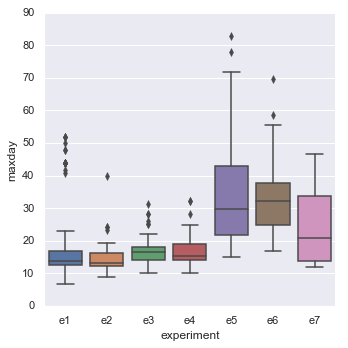

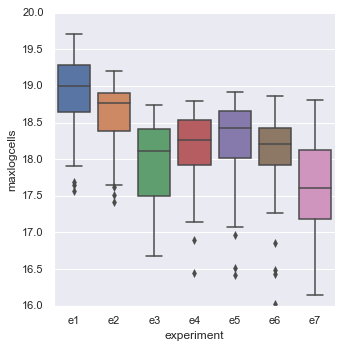

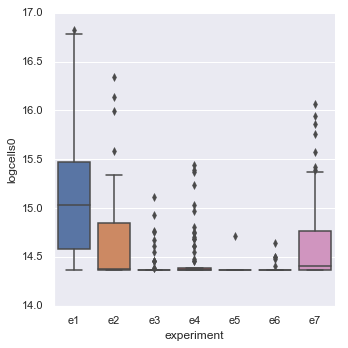

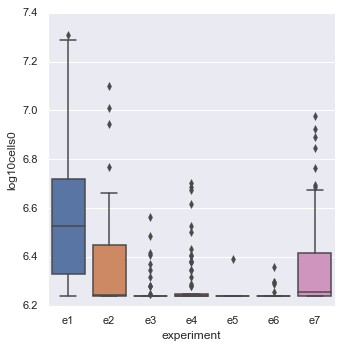

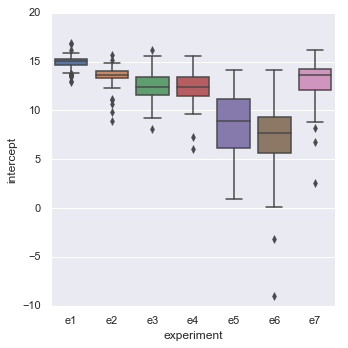

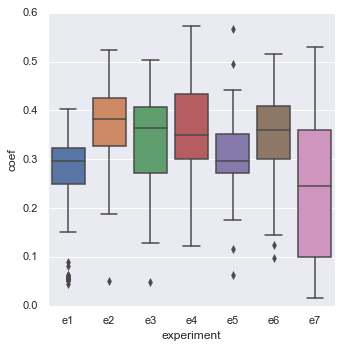

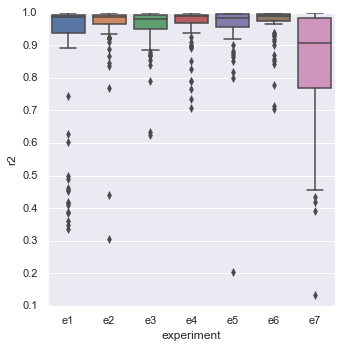

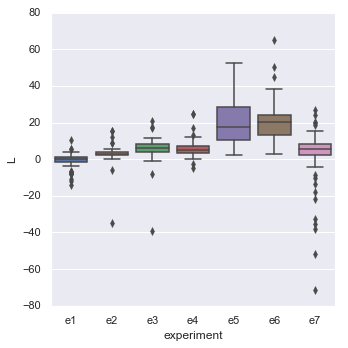

In [309]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box')

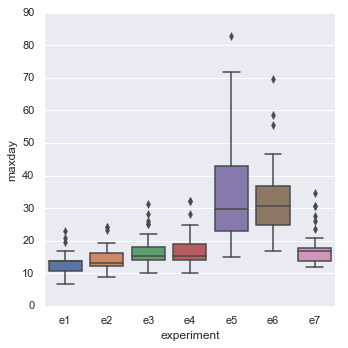

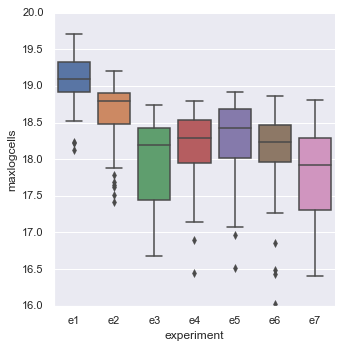

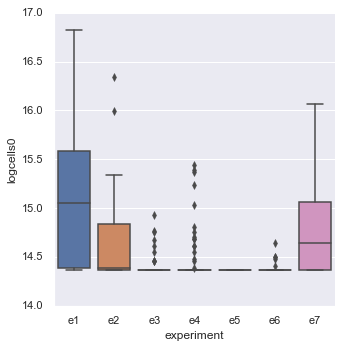

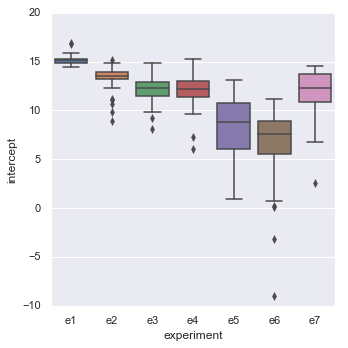

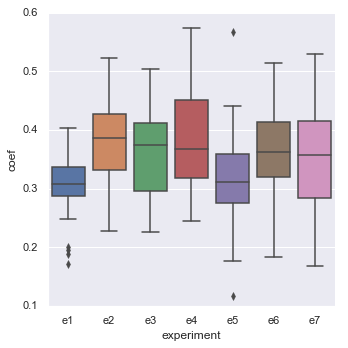

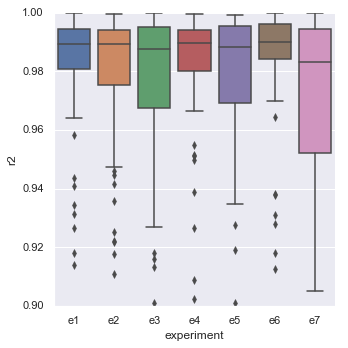

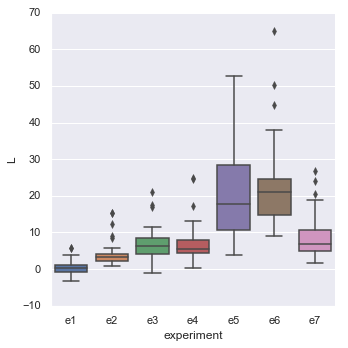

In [310]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'intercept', 'coef', 'r2', 'L']:
    sns.catplot(data=lagsdf.loc[lagsdf.r2 > 0.9], 
                x='experiment', y=i, kind='box')

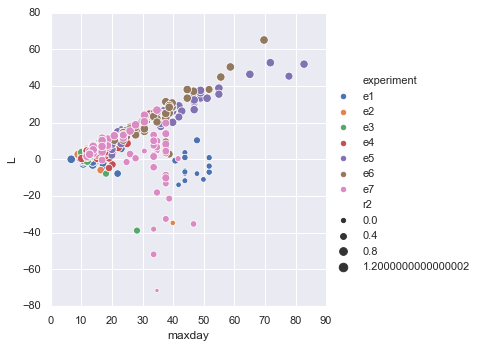

In [311]:
sns.relplot(data=lagsdf, x='maxday', y='L', hue='experiment', size='r2')

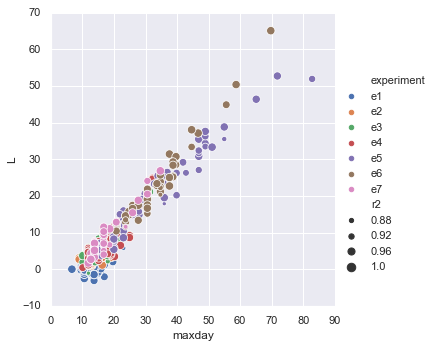

In [312]:
sns.relplot(data=lagsdf.loc[lagsdf.r2 > 0.9], x='maxday', y='L', hue='experiment', size='r2')

In [313]:
worse_l = lagsdf.nsmallest(10, 'L')['experiment_sample']

In [314]:
lagsdf.nsmallest(10, 'r2')

,experiment,sample,PRO,ALT,culture,experiment_sample,maxday,minday,maxlogcells,logcells0,log10cells0,intercept,coef,r2,L,initial_logcells
509,e7,36A,allP,all_Pro,All_Pro,"e7, 36A",34.710000,18.650000,16.149894,14.404044,6.255597,15.382971,0.016416,0.133790,-71.637655,NaN
345,e5,19B,Natl2A,BS11,Co_Culture,"e5, 19B",19.970000,11.880000,18.535512,14.364823,6.238564,12.473919,0.267521,0.203294,4.379889,NaN
111,e2,16C,MED4,BS11,Co_Culture,"e2, 16C",39.870000,5.100000,18.144914,14.364823,6.238564,14.684206,0.050652,0.304236,-34.758360,NaN
84,e1,7C,MIT9313,DE,Co_Culture,"e1, 7C",41.764583,0.000000,18.165244,15.197733,6.600291,13.871367,0.053279,0.335847,-13.933271,6.0
23,e1,17C,MIT9313,BS11,Co_Culture,"e1, 17C",47.781250,0.000000,17.934356,15.456747,6.712780,13.915956,0.044548,0.348342,-7.835507,6.0
40,e1,22B,MIT9313,ATCC,Co_Culture,"e1, 22B",49.885417,0.715972,18.057695,15.017149,6.521865,13.764833,0.049942,0.359290,-10.996208,6.0
7,e1,12B,MIT9313,DE1,Co_Culture,"e1, 12B",43.836806,0.715972,17.964325,15.027511,6.526365,13.689462,0.057010,0.384217,-7.677261,6.0
6,e1,12A,MIT9313,DE1,Co_Culture,"e1, 12A",43.836806,0.715972,17.989164,14.627188,6.352507,13.641126,0.060541,0.386871,-11.695445,6.0
467,e7,12C,MIT9313,DE1,Co_Culture,"e7, 12C",30.590000,16.760000,16.723789,14.364823,6.238564,13.654531,0.090371,0.390828,4.486780,NaN
8,e1,12C,MIT9313,DE1,Co_Culture,"e1, 12C",43.836806,0.715972,17.901134,14.930137,6.484076,13.669310,0.059173,0.409630,-6.371936,6.0


In [315]:
def plot_growth(es):
    sns.set(rc={'figure.figsize':(10,5)})
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(es)
    plt.show()


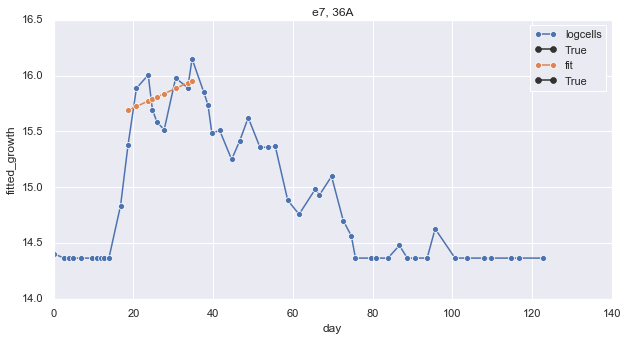

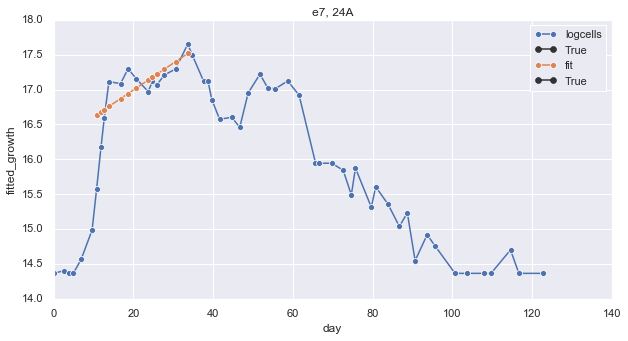

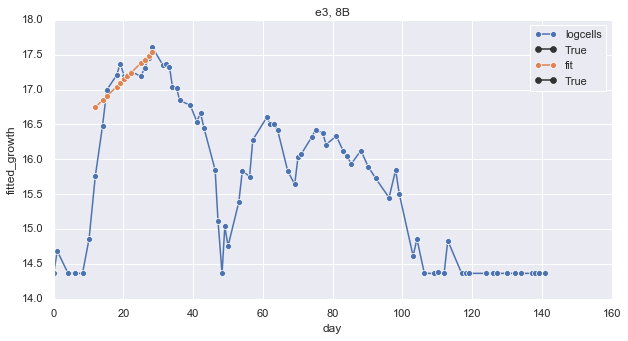

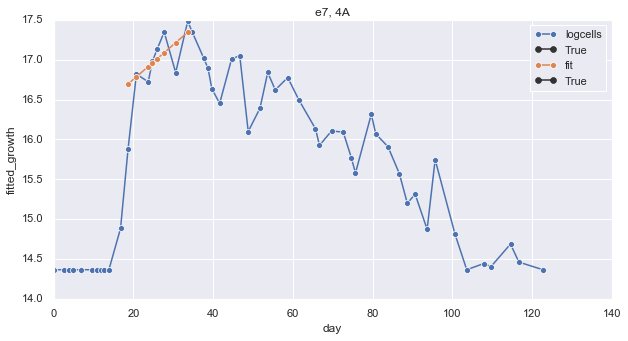

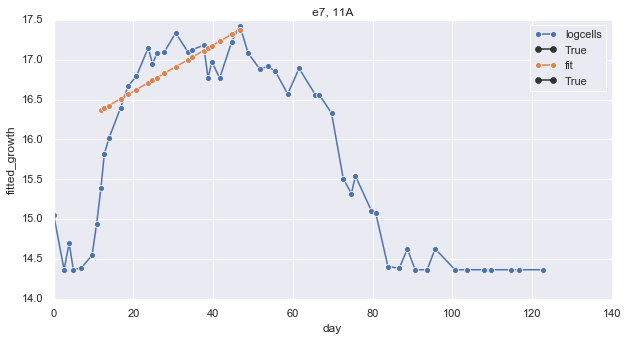

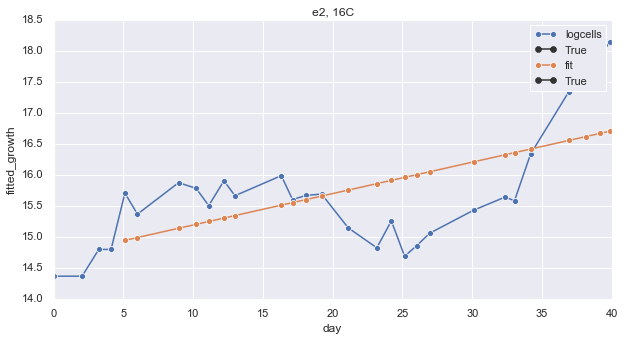

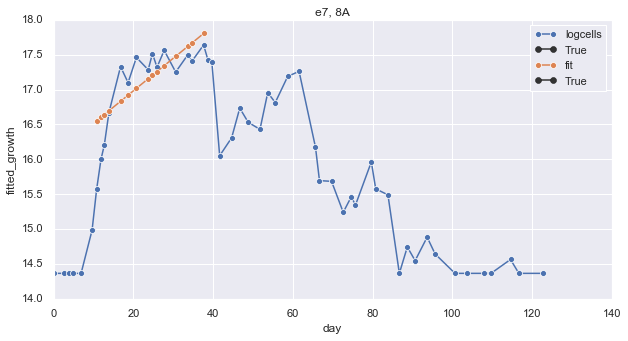

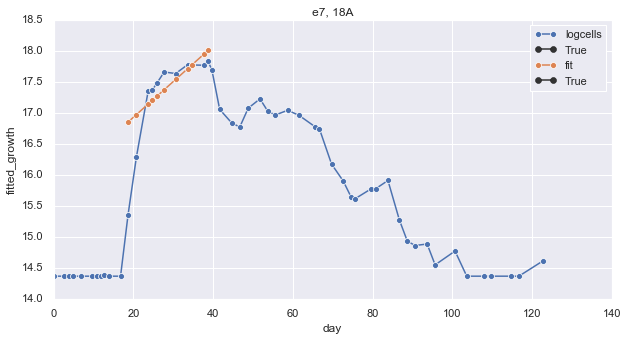

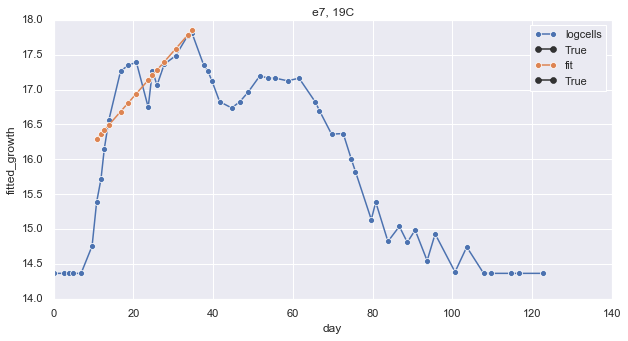

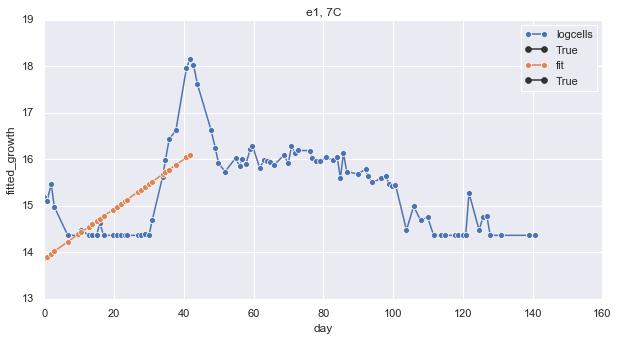

In [316]:
for es in worse_l:
    plot_growth(es)

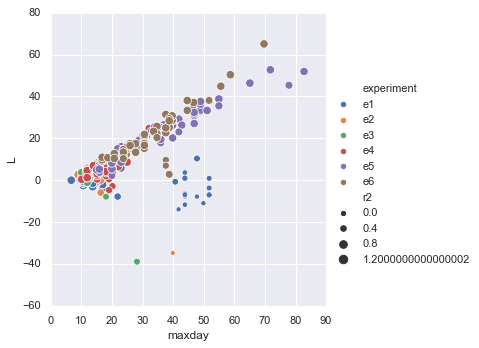

In [298]:
sns.relplot(data=lagsdf, x='maxday', y='L', hue='experiment', size='r2')

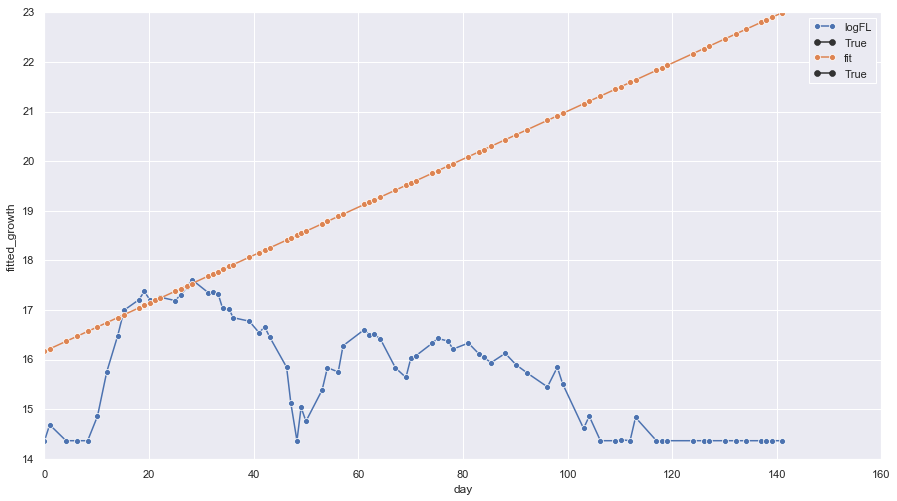

In [319]:
sns.set(rc={'figure.figsize':(15,8)})
es = 'e3, 8B'
d = df.loc[df.experiment_sample == es].reset_index()
d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
sns.lineplot(data=d,
             x='day', y='logcells',  style=True, markers=True,label='logFL')
sns.lineplot(data=d,
    x='day', y='fitted_growth',  style=True, markers=True,label='fit')

#sns.lineplot(data=d, x='day', y='first_deriviative',  style=True, markers=True,label='1')
#sns.lineplot(data=d, x='day', y='second_deriviative',  style=True, markers=True,label='2')

In [328]:
d['positive_logFL'] = d.logFL
d.loc[d.ratelogFL <0, 'positive_logFL' ] = np.Nan

AttributeError: 'DataFrame' object has no attribute 'ratelog'

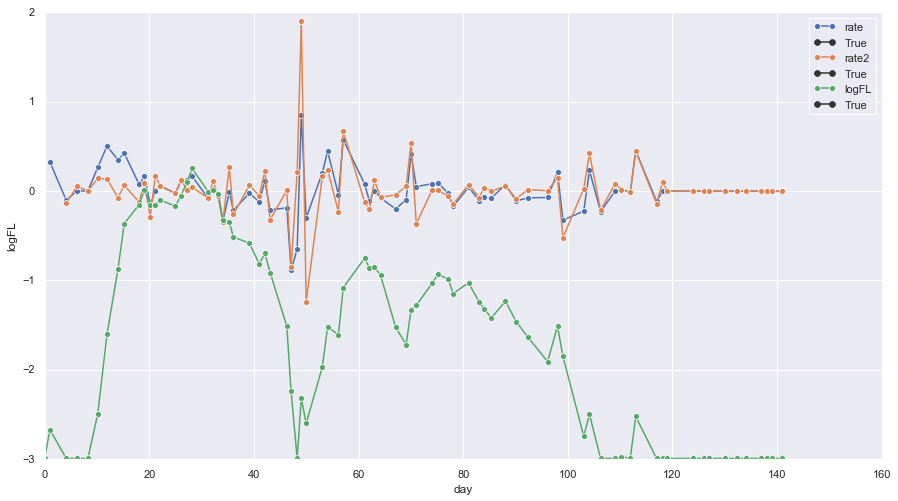

In [327]:
d['rate2logFL'] = (d['ratelogFL'] - d['ratelogFL'].shift()) / d['diffday']
sns.lineplot(data=d,
             x='day', y='ratelogFL',  style=True, markers=True,label='rate')
sns.lineplot(data=d,
             x='day', y='rate2logFL',  style=True, markers=True,label='rate2')
sns.lineplot(data=d,
    x='day', y='logFL',  style=True, markers=True,label='logFL')

#sns.lineplot(data=d, x='day', y='first_deriviative',  style=True, markers=True,label='1')
#sns.lineplot(data=d, x='day', y='second_deriviative',  style=True, markers=True,label='2')

In [320]:
d.head()

,index,day,experiment,sample,FL,PRO,ALT,culture,FL_orig,logFL,...,zscoreFL,diffFL,difflogFL,diffday,rateFL,ratelogFL,experiment_sample,cells,logcells,fitted_growth
0,1738,0.00,e3,8B,0.050,MIT9312,DE,Co_Culture,0.050,-2.995732,...,-0.874237,NaN,NaN,NaN,NaN,NaN,"e3, 8B",1.732062e+06,14.364823,16.168764
1,1739,0.99,e3,8B,0.069,MIT9312,DE,Co_Culture,0.069,-2.673649,...,-0.815308,0.019,0.322083,0.99,0.019192,0.325337,"e3, 8B",2.390246e+06,14.686907,16.216688
2,1740,4.11,e3,8B,0.050,MIT9312,DE,Co_Culture,0.001,-2.995732,...,-0.874237,-0.019,-0.322083,3.12,-0.006090,-0.103232,"e3, 8B",1.732062e+06,14.364823,16.367721
3,1741,6.17,e3,8B,0.050,MIT9312,DE,Co_Culture,0.037,-2.995732,...,-0.874237,0.000,0.000000,2.06,0.000000,0.000000,"e3, 8B",1.732062e+06,14.364823,16.467442
4,1742,8.25,e3,8B,0.050,MIT9312,DE,Co_Culture,0.037,-2.995732,...,-0.874237,0.000,0.000000,2.08,0.000000,0.000000,"e3, 8B",1.732062e+06,14.364823,16.568130


In [322]:
d.logFL.shift()

0          NaN
1    -2.995732
2    -2.673649
3    -2.995732
4    -2.995732
        ...   
74   -2.995732
75   -2.995732
76   -2.995732
77   -2.995732
78   -2.995732
Name: logFL, Length: 79, dtype: float64

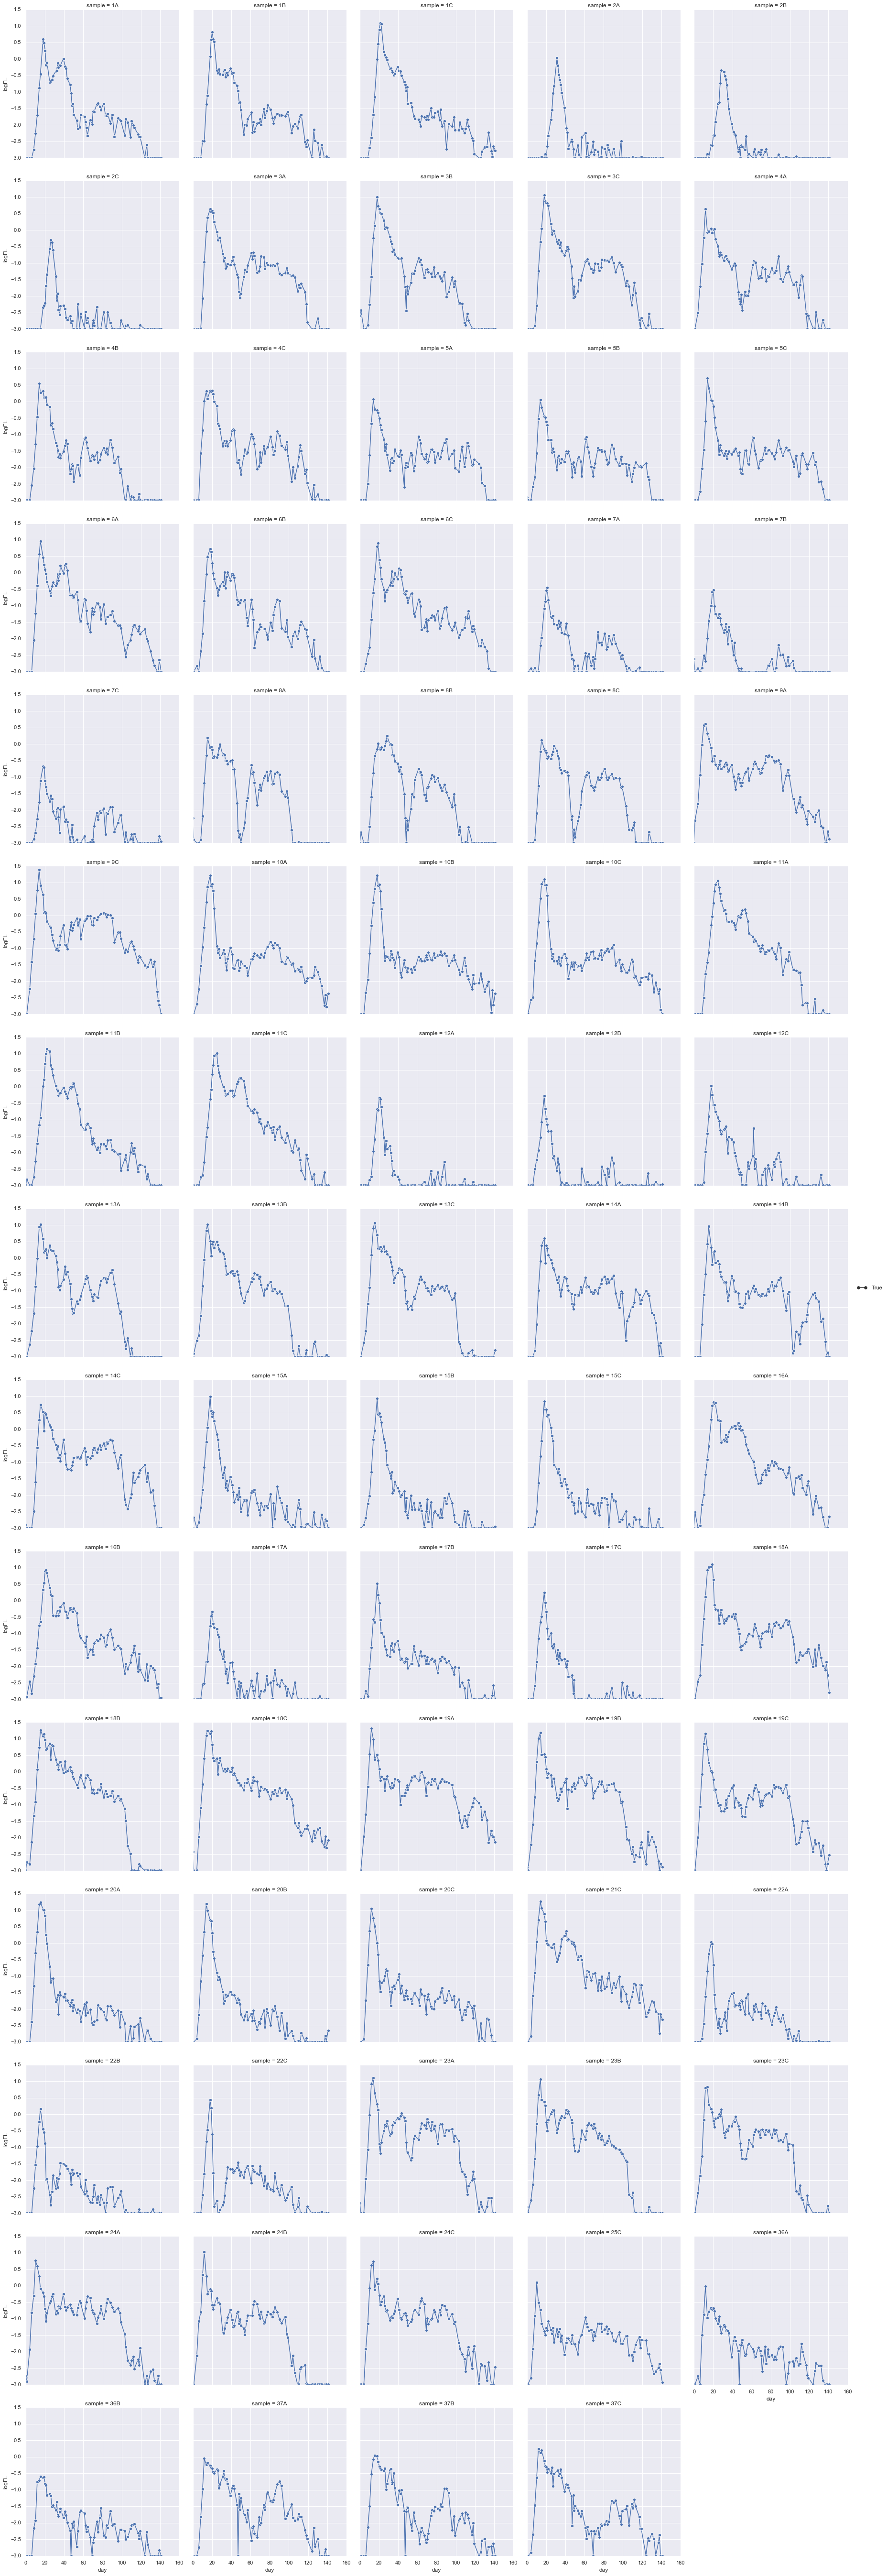

In [300]:
sns.relplot(data=df.loc[df.experiment == 'e3'],
            col='sample', col_wrap=5,
            x='day', y='logFL', kind='line', style=True, markers=True)

In [317]:
d = df.loc[df.experiment_sample == 'e3, 8B']